In [1]:
from ecnet.datasets import load_cn, load_ysi
smiles_cn, cn = load_cn()
smiles_ysi, ysi = load_ysi()
ysi = [[y[0] / 10.0] for y in ysi]
smiles_common = []
vals_common = []
for idx, csmi in enumerate(smiles_cn):
    for ysmi in smiles_ysi:
        if csmi == ysmi:
            smiles_common.append(csmi)
            vals_common.append([cn[idx][0], ysi[idx][0]])
print(len(smiles_common), len(vals_common), len(vals_common[0]))

132 132 2


In [2]:
from ecnet.datasets.structs import QSPRDataset
dataset = QSPRDataset(smiles=smiles_common, target_vals=vals_common, backend='alvadesc')
print(dataset.desc_vals.shape, dataset.target_vals.shape)

torch.Size([132, 5305]) torch.Size([132, 2])


In [3]:
from sklearn.model_selection import train_test_split
from copy import deepcopy

index_train, index_test = train_test_split([i for i in range(len(dataset))],
                                           test_size=0.2, random_state=42)
dataset_train = deepcopy(dataset)
dataset_train.set_index(index_train)
dataset_test = deepcopy(dataset)
dataset_test.set_index(index_test)
print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)

torch.Size([105, 5305]) torch.Size([27, 5305])


In [4]:
from ecnet.tasks.feature_selection import select_rfr
desc_idx, desc_imp = select_rfr(dataset_train, total_importance=0.95,
                                n_estimators=100, n_jobs=4)
dataset_train.set_desc_index(desc_idx)
dataset_test.set_desc_index(desc_idx)
desc_names = [dataset.desc_names[i] for i in desc_idx]
print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)
print(desc_names[:5], len(desc_names))
print(desc_imp[:5])

torch.Size([105, 219]) torch.Size([27, 219])
['PHI', 'S2K', 'RBF', 'ChiA_B(s)', 'Chi_Dz(v)'] 219
[0.24915499070661248, 0.09787116659947559, 0.0480861330204689, 0.040167452915412266, 0.03690466807390161]


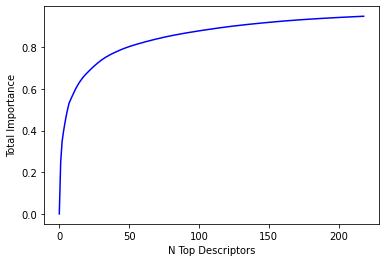

In [5]:
from matplotlib import pyplot as plt
plt.clf()
x_vals = [i for i in range(len(desc_imp))]
y_vals = [0.0]
for idx in range(len(desc_imp) - 1):
    y_vals.append(sum(desc_imp[:idx + 1]))
x_vals = x_vals[:250]
y_vals = y_vals[:250]
plt.xlabel('N Top Descriptors')
plt.ylabel('Total Importance')
plt.plot(x_vals, y_vals, color='blue')
plt.show()

In [91]:
from ecnet import ECNet

model = ECNet(dataset_train.desc_vals.shape[1], dataset_train.target_vals.shape[1],
              256, 2)
train_loss, valid_loss = model.fit(
    dataset=dataset_train, valid_size=0.2, verbose=10,
    patience=100, epochs=500, random_state=12, lr=0.002, lr_decay=0.000005
)

Epoch: 0 | Train loss: 937.6482631138393 | Valid loss: 9223372036854775807
Epoch: 10 | Train loss: 515.2571847098214 | Valid loss: 381.62640380859375
Epoch: 20 | Train loss: 277.794430687314 | Valid loss: 168.47216796875
Epoch: 30 | Train loss: 199.46808079310827 | Valid loss: 175.9431915283203
Epoch: 40 | Train loss: 129.08699180966332 | Valid loss: 97.55359649658203
Epoch: 50 | Train loss: 87.86568505423409 | Valid loss: 79.12625122070312
Epoch: 60 | Train loss: 63.46900503976004 | Valid loss: 83.04481506347656
Epoch: 70 | Train loss: 50.02490543183826 | Valid loss: 95.28618621826172
Epoch: 80 | Train loss: 58.62040819440569 | Valid loss: 88.38362884521484
Epoch: 90 | Train loss: 58.35040928068615 | Valid loss: 139.80828857421875
Epoch: 100 | Train loss: 32.42879213605608 | Valid loss: 102.90657806396484
Epoch: 110 | Train loss: 37.625792003813245 | Valid loss: 111.71890258789062
Epoch: 120 | Train loss: 29.117579868861608 | Valid loss: 104.37113952636719
Epoch: 130 | Train loss: 22.

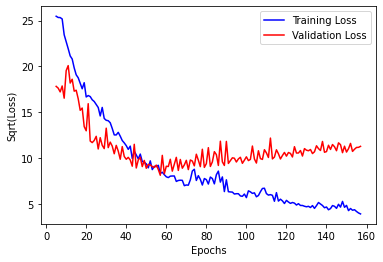

In [92]:
from math import sqrt

train_loss = [sqrt(l) for l in train_loss][5:]
valid_loss = [sqrt(l) for l in valid_loss][5:]
epoch = [i for i in range(5, len(train_loss) + 5)]
plt.clf()
plt.xlabel('Epochs')
plt.ylabel('Sqrt(Loss)')
plt.plot(epoch, train_loss, color='blue', label='Training Loss')
plt.plot(epoch, valid_loss, color='red', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [93]:
from sklearn.metrics import median_absolute_error, r2_score

y_hat_train = model(dataset_train.desc_vals).detach().numpy()
y_train = dataset_train.target_vals.numpy()
y_hat_test = model(dataset_test.desc_vals).detach().numpy()
y_test = dataset_test.target_vals.numpy()

y_hat_train_cn = [y[0] for y in y_hat_train]
y_hat_train_ysi = [y[1] * 10 for y in y_hat_train]
y_train_cn = [y[0] for y in y_train]
y_train_ysi = [y[1] * 10 for y in y_train]

y_hat_test_cn = [y[0] for y in y_hat_test]
y_hat_test_ysi = [y[1] for y in y_hat_test]
y_test_cn = [y[0] for y in y_test]
y_test_ysi = [y[1] for y in y_test]

mae_cn_train = median_absolute_error(y_hat_train_cn, y_train_cn)
mae_cn_test = median_absolute_error(y_hat_test_cn, y_test_cn)
mae_ysi_train = median_absolute_error(y_hat_train_ysi, y_train_ysi)
mae_ysi_test = median_absolute_error(y_hat_test_ysi, y_test_ysi)
r2_cn_train = r2_score(y_hat_train_cn, y_train_cn)
r2_cn_test = r2_score(y_hat_test_cn, y_test_cn)
r2_ysi_train = r2_score(y_hat_train_ysi, y_train_ysi)
r2_ysi_test = r2_score(y_hat_test_ysi, y_test_ysi)

print(f'CN Train: {mae_cn_train} | {r2_cn_train}')
print(f'CN Test: {mae_cn_test} | {r2_cn_test}')
print(f'YSI Train: {mae_ysi_train} | {r2_ysi_train}')
print(f'YSI Test: {mae_ysi_test} | {r2_ysi_test}')

CN Train: 2.1248035430908203 | 0.9484218050927915
CN Test: 4.027780532836914 | 0.04385905048079386
YSI Train: 17.089157104492188 | 0.8958528563863021
YSI Test: 5.721216201782227 | 0.09395164818501989


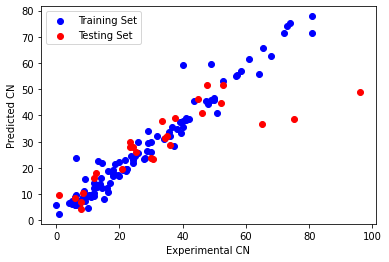

In [94]:
plt.clf()
plt.xlabel('Experimental CN')
plt.ylabel('Predicted CN')
plt.scatter(y_train_cn, y_hat_train_cn, color='blue', label='Training Set')
plt.scatter(y_test_cn, y_hat_test_cn, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()

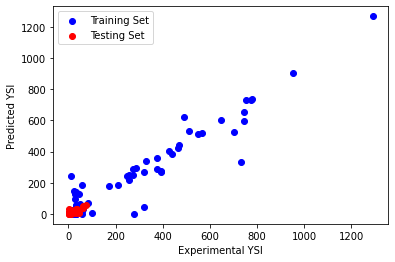

In [95]:
plt.clf()
plt.xlabel('Experimental YSI')
plt.ylabel('Predicted YSI')
plt.scatter(y_train_ysi, y_hat_train_ysi, color='blue', label='Training Set')
plt.scatter(y_test_ysi, y_hat_test_ysi, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()